In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import os

from script.create_sequences import create_sequences, create_sequences_many
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, LayerNormalization, LeakyReLU, Input, RepeatVector,TimeDistributed
from script.generate_multivariate_samples import generate_multivariate_samples
import numpy as np
import plotly.graph_objs as go

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all = df_all[(df_all['Date'] > pd.to_datetime('2020-11-24')) & (df_all['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)

In [15]:
df_all_open_n_high = pd.read_csv('merged_data.csv', thousands=',')
df_all_open_n_high['Date'] = pd.to_datetime(df_all_open_n_high['Date'], format='%Y-%m-%d')  
df_all_open_n_high = df_all_open_n_high.sort_values(by = 'Date', ascending=True).reset_index(drop = True)
df_all_open_n_high = df_all_open_n_high[(df_all_open_n_high['Date'] > pd.to_datetime('2020-11-24')) & (df_all_open_n_high['Date'] < pd.to_datetime('2024-10-07'))].reset_index(drop=True)

In [19]:
df_all = pd.merge(left = df_all, right = df_all_open_n_high[['Date', 'High_price', 'Low_price']], how = 'left', left_on = 'Date', right_on = 'Date')

In [20]:
df_all.head()

,Date,EUA,Market_size,Oil,Coal,NG,Power,IR,GDP,USEU,S&P_clean,DAX,High_price,Low_price
0,2020-11-25,28.04,193756.4,48.61,53.6,13.932,38.77,0.0,3610544.5,0.8392,1472.35,13289.80,28.45,27.98
1,2020-11-26,28.54,218045.6,47.80,53.6,13.914,38.77,0.0,3610544.5,0.8392,1467.14,13286.57,28.62,27.82
2,2020-11-27,28.59,109785.6,48.18,53.8,14.485,38.77,0.0,3610544.5,0.8358,1498.84,13335.68,29.10,28.34
3,2020-11-28,28.59,109785.6,48.18,53.8,14.485,38.77,0.0,3610544.5,0.8358,1498.84,13335.68,29.10,28.34
4,2020-11-29,28.59,109785.6,48.18,53.8,14.485,38.77,0.0,3610544.5,0.8358,1498.84,13335.68,29.10,28.34


<Axes: xlabel='Date'>

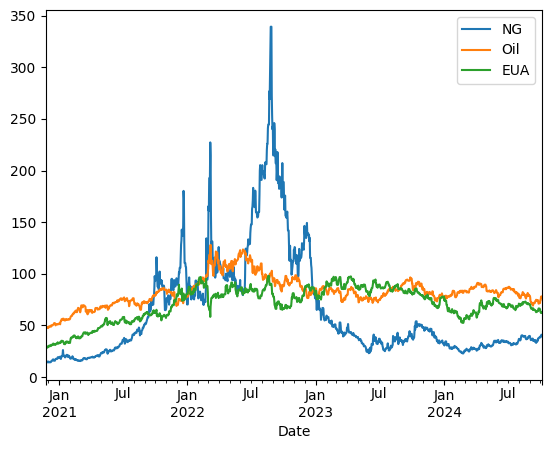

In [21]:
df_all.plot(x='Date', y=['NG','Oil', 'EUA'])

In [ ]:
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [32]:
def generate_lstm_multi_step(X_train, y_train):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    model = Sequential()
    # First LSTM layer with LayerNormalization and recurrent dropout
    model.add(LSTM(256, input_shape=(n_timesteps, n_features),
                activation='relu', recurrent_activation='sigmoid',
                recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(256, activation='relu', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))

    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    # Compile the model using AdamW optimizer and a learning rate scheduler
    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)  # AdamW improves generalization
    model.compile(optimizer=optimizer, loss='mse')

    return model


In [43]:
def generate_lstm():
    # Learning rate scheduler function

        # else:
        #     return lr * np.exp(-0.1)

    model = Sequential()

    # First LSTM layer with LayerNormalization and recurrent dropout
    model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]),
                activation='tanh', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())
    # model.add(Dropout(0.1))

    # Second LSTM layer with residual connection, LayerNormalization, and recurrent dropout
    model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid',
                return_sequences=True, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())
    # model.add(Dropout(0.1))

    # Third LSTM layer (final) without returning sequences, adding residual connection
    model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid',
                return_sequences=False, recurrent_dropout=0.2,
                kernel_regularizer=l2(0.001)))
    model.add(LayerNormalization())

    # Dense layer with LeakyReLU activation for flexibility in output
    model.add(Dense(len(predictors_lst)*30))
    model.add(LeakyReLU(alpha=0.1))  # LeakyReLU is more flexible for output regression

    # Compile the model using AdamW optimizer and a learning rate scheduler
    optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)  # AdamW improves generalization
    model.compile(optimizer=optimizer, loss='mse')

    return model


In [33]:
def train_lstm_multi_step(model, checkpoint_path, X_train, y_train,):
    try:
        model.load_weights(checkpoint_path) 
        # with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'rb') as f:
        #     history = pickle.load(f)
    except:
        def lr_scheduler(epoch, lr):
        # if epoch < 10:
            return lr
        # Learning rate scheduler callback
        lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

        checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                    monitor='val_loss', 
                                    save_best_only=True,
                                    mode='min',  
                                    verbose=1)

        early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

        history = model.fit(X_train, y_train, epochs=100, batch_size=10, 
                            validation_split=0.05,
                            verbose=1, callbacks=[checkpoint, lr_scheduler_callback, early_stopping])# ,early_stopping]) 
        
        with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'wb') as f:
            pickle.dump(history, f)
    # return history


In [3]:
from script.curate_training_test_data import curate_training_test_data, curate_training_test_data_many

In [27]:
X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
    df_all, 
    flatten=False,
    sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
    sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
    test_date='2024-07-01',
    predictors_lst=['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean', 'High_price', 'Low_price']
)

# 디버그: X_train과 y_train의 모양 확인
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (1259, 28, 8), y_train shape: (1259, 28, 8)


In [ ]:
predictors_lst =['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean', 'High_price', 'Low_price']
test_date = '2024-08-01'

folder_name = "LSTM_multi_steps"
modeltype='lstm'

for sequence_length in [28]:

    original_EUA = df_all['EUA'].values  
    dates = df_all['Date'].values
    last_train_date = pd.to_datetime(test_date) - pd.to_timedelta(1, unit = 'day')
    X_train, y_train, X_test, y_test, scaler = curate_training_test_data_many(
                                                df_all, 
                                                flatten=False,
                                                sequence_length_input=28,  # 입력 시퀀스 길이 (30일)
                                                sequence_length_out=28,  # 입력 시퀀스 길이 (30일)
                                                test_date='2024-07-01',
                                                predictors_lst=['EUA','Oil', 'Coal','Power', 'GDP', 'S&P_clean', 'High_price', 'Low_price']
                                            )

    checkpoint_path = f"./{folder_name}/{modeltype}_ts_{sequence_length}.keras"

    model = generate_lstm_multi_step(X_train, y_train)
    history = train_lstm_multi_step(model, checkpoint_path, X_train, y_train,)
    model.load_weights(checkpoint_path) 

    # accuracy plot
    train_predictions = model.predict(X_train, verbose = 0);
    train_predictions_rescaled = scaler.inverse_transform(train_predictions.reshape(-1, len(predictors_lst)))
    test_predictions = model.predict(X_test, verbose = 0);
    test_predictions_rescaled = scaler.inverse_transform(test_predictions.reshape(-1, len(predictors_lst)))


c:\Users\kangs\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8778
Epoch 1: val_loss improved from inf to 0.49314, saving model to ./LSTM_multi_steps/lstm_ts_28.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.8757 - val_loss: 0.4931 - learning_rate: 0.0010
Epoch 2/100
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6239
Epoch 2: val_loss improved from 0.49314 to 0.45822, saving model to ./LSTM_multi_steps/lstm_ts_28.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.6238 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 3/100
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6028
Epoch 3: val_loss improved from 0.45822 to 0.45048, saving model to ./LSTM_multi_steps/lstm_ts_28.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.6027 - val_loss: 0.4505 - learning_rate: 0.0010
Epoch 4/100
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6123
Epoch 4: val_loss improved from 0.45048 to 0.44581, saving model to ./LSTM_multi_steps/lstm_ts_28.keras
120/120 ━━━━

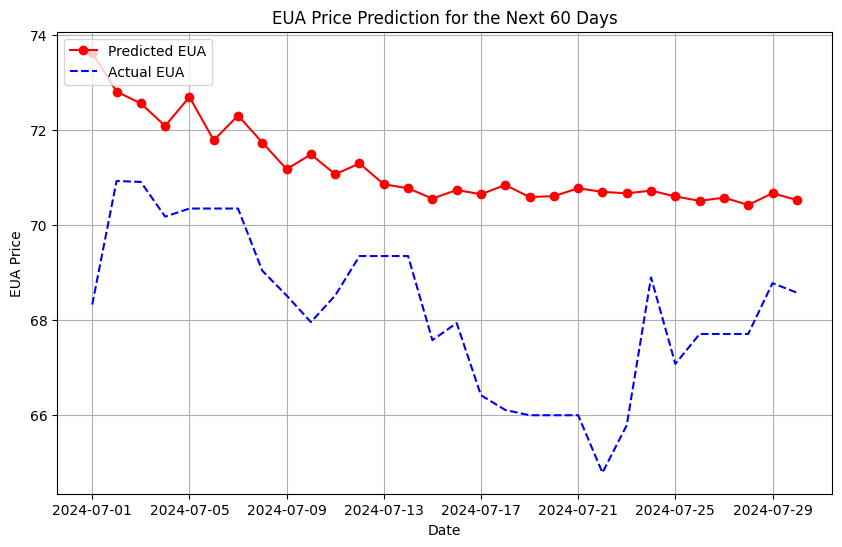

In [61]:

# 예측된 60일치의 EUA 값만 추출
predicted_eua = test_predictions_rescaled[:30, 0]  # 첫 번째 변수(EUA)만 추출
actual_eua = df_all[df_all['Date'] >= test_date]['EUA'].values[:30]  # 실제 EUA 값

# 60일 동안의 날짜 생성
future_dates = [last_train_date + pd.DateOffset(days=i + 1) for i in range(30)]

# 그래프 그리기
plt.figure(figsize=(10, 6))

# 예측된 EUA 가격 그래프
plt.plot(future_dates, predicted_eua, label='Predicted EUA', color='red', marker='o')

# 실제 EUA 가격 그래프
plt.plot(future_dates, actual_eua, label='Actual EUA', color='blue', linestyle='--')

# 그래프 설정
plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.title('EUA Price Prediction for the Next 60 Days')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()